In [148]:
import pandas as pd


clients = pd.read_csv("datos/caso_2/clients.csv")
depots = pd.read_csv("datos/caso_2/depots.csv")
depots = depots.drop(columns=["DepotID"])
vehicles = pd.read_csv("datos/caso_2/vehicles.csv")

# clients = pd.read_csv("datos/caso_2_petite/clients.csv")
# depots = pd.read_csv("datos/caso_2_petite/depots.csv")
# depots = depots.drop(columns=["DepotID"])
# vehicles = pd.read_csv("datos/caso_2_petite/vehicles.csv")



print(clients.head())
print(depots.head())
print(vehicles.head())


   LocationID  ClientID   Latitude  Longitude  Demand   TimeWindow
0           2         1  12.341057 -71.723837    25.0  13:20-13:50
1           3         2  12.310993 -71.719252     9.0  13:30-14:00
2           4         3  12.326781 -71.668190    18.0  10:15-10:45
3           5         4  12.330562 -71.694530    22.0  13:00-13:30
4           6         5  12.346781 -71.708920    13.0  14:50-15:20
   LocationID  Latitude  Longitude
0           1  12.31846 -71.716203
   VehicleID   Type  Capacity  Range  Speed
0          1    4x4     200.0  804.0    NaN
1          2  drone      25.0  480.0  135.0
2          3  drone      25.0  480.0  135.0


In [149]:
from haversine import haversine


def dehhmm_a_minutos(hhmm):
    """
    Convierte un tiempo en formato de horas y minutos (HHMM) a minutos.
    :param dehhmm: Tiempo en formato HHMM.
    :return: Tiempo en minutos.
    """
    horas = hhmm // 100
    minutos = hhmm % 100
    return horas * 60 + minutos

def minutos_a_dehhmm(minutos):
    """
    Convierte un tiempo en minutos a formato de horas y minutos (HHMM).
    :param minutos: Tiempo en minutos.
    :return: Tiempo en formato HHMM.
    """
    horas = minutos // 60
    minutos = minutos % 60
    return horas * 100 + minutos


# recibe "hh:mm-hh:mm" y devuelve una lista de tuplas con los tiempos en minutos
def convertir_hora_a_minutos(rango_horas):
    """
    Convierte un rango de horas en formato "hh:mm-hh:mm" a una lista de tuplas con los tiempos en minutos.
    :param rango_horas: Rango de horas en formato "hh:mm-hh:mm".
    :return: tiempos en minutos.
    """
    inicio, fin = rango_horas.split('-')
    inicio_min = dehhmm_a_minutos(int(inicio.replace(':', '')))
    fin_min = dehhmm_a_minutos(int(fin.replace(':', '')))
    return [inicio_min, fin_min]

# haversine

def haversine_distance(coord1, coord2):
    """
    Calculate the haversine distance between two coordinates.
    :param coord1: Tuple of (latitude, longitude) for the first coordinate.
    :param coord2: Tuple of (latitude, longitude) for the second coordinate.
    :return: Distance in kilometers.
    """
    return haversine(coord1, coord2)

In [150]:

depots = depots.rename(columns={"LocationID": "id"})
clients = clients.rename(columns={"LocationID": "id"})
depots["id"] = 0 
depots["Demand"] = 0

clients = clients.reset_index(drop=True)
clients["id"] = clients.index + 1  

depots = depots[["id", "Longitude", "Latitude", "Demand"]]
clients = clients[["id", "Longitude", "Latitude", "Demand","TimeWindow"]]

print(clients)


# # adactaciones caso 2: depot se multiplica por 6

# depots = pd.concat([depots]*6, ignore_index=True)


nodes = pd.concat([depots, clients], ignore_index=True)

print("Nodos:")
print(nodes)


N = nodes["id"].tolist()

C = clients["id"].tolist()



De = nodes.set_index("id")["Demand"].to_dict()

depot = 0

V = vehicles["VehicleID"].tolist()
P = vehicles.set_index("VehicleID")["Capacity"].to_dict()
M = vehicles.set_index("VehicleID")["Range"].to_dict()



# Adaptaciones caso 2


tipo_vehiculo = [ 1 if v == "4x4" else 2 for v in vehicles["Type"].tolist() ] # 1: carros, 2: drones

print("Tipo de vehiculo:", tipo_vehiculo)

K = [1,2] # 1: carros, 2 drones

distances = {}

for i in range(len(nodes)):
    for j in range(len(nodes)):
        for k in K:
            if i != j and k == 1: # solo para carros
                coord1 = (nodes.iloc[i]["Latitude"], nodes.iloc[i]["Longitude"])
                coord2 = (nodes.iloc[j]["Latitude"], nodes.iloc[j]["Longitude"])
                distances[(nodes.iloc[i]["id"], nodes.iloc[j]["id"], k)] = haversine_distance(coord1, coord2) *1.3 # 30% más por ser un carro
            if i != j and k == 2: # solo para drones
                coord1 = (nodes.iloc[i]["Latitude"], nodes.iloc[i]["Longitude"])
                coord2 = (nodes.iloc[j]["Latitude"], nodes.iloc[j]["Longitude"])
                distances[(nodes.iloc[i]["id"], nodes.iloc[j]["id"], k)] = haversine_distance(coord1, coord2) # No hay penalización de distancia

# Agregar el minuto al que tiene que llegar el cliente, puede llegar a cualquier hora al nodo 0
VT = ([convertir_hora_a_minutos(i) for i in clients["TimeWindow"].tolist()])
VT.insert(0, [0, 1440]) # el depot puede llegar a cualquier hora

print("Nodos:", N)
print("Clientes:", C)
print("Vehículos:", V)
print("Capacidades:", P)
print("Alcances:", M)
print("Demanda:", De)
print("Tipo de vehiculo:", tipo_vehiculo)
print("Distancias:", distances)
print("Ventanas de tiempo:", VT)

print(N)


    id  Longitude   Latitude  Demand   TimeWindow
0    1 -71.723837  12.341057    25.0  13:20-13:50
1    2 -71.719252  12.310993     9.0  13:30-14:00
2    3 -71.668190  12.326781    18.0  10:15-10:45
3    4 -71.694530  12.330562    22.0  13:00-13:30
4    5 -71.708920  12.346781    13.0  14:50-15:20
5    6 -71.742310  12.315673     4.0  09:00-09:30
6    7 -71.720560  12.298345     5.0  09:11-09:41
7    8 -71.682340  12.322089    10.0  08:15-08:45
8    9 -71.701230  12.305627     9.0  14:18-14:48
9   10 -71.735670  12.337812     9.0  14:30-15:00
10  11 -71.678900  12.313405    10.0  08:30-09:00
11  12 -71.727890  12.319872    24.0  13:10-13:40
12  13 -71.712340  12.332456    12.0  14:40-15:10
13  14 -71.698760  12.347123    15.0  15:00-15:30
Nodos:
    id  Longitude   Latitude  Demand   TimeWindow
0    0 -71.716203  12.318460     0.0          NaN
1    1 -71.723837  12.341057    25.0  13:20-13:50
2    2 -71.719252  12.310993     9.0  13:30-14:00
3    3 -71.668190  12.326781    18.0  10:15

In [151]:
print(distances)

{(np.int64(0), np.int64(1), 1): 3.439820297737471, (np.int64(0), np.int64(1), 2): 2.6460156136442086, (np.int64(0), np.int64(2), 1): 1.1621579203687056, (np.int64(0), np.int64(2), 2): 0.8939676310528504, (np.int64(0), np.int64(3), 1): 6.8863931713672075, (np.int64(0), np.int64(3), 2): 5.297225516436313, (np.int64(0), np.int64(4), 1): 3.525329536814699, (np.int64(0), np.int64(4), 2): 2.7117919513959223, (np.int64(0), np.int64(5), 1): 4.221074201758693, (np.int64(0), np.int64(5), 2): 3.2469801551989947, (np.int64(0), np.int64(6), 1): 3.708981644905904, (np.int64(0), np.int64(6), 2): 2.853062803773772, (np.int64(0), np.int64(7), 1): 2.9721357282532423, (np.int64(0), np.int64(7), 2): 2.286258252502494, (np.int64(0), np.int64(8), 1): 4.81093076951533, (np.int64(0), np.int64(8), 2): 3.7007159765502537, (np.int64(0), np.int64(9), 1): 2.812974341701751, (np.int64(0), np.int64(9), 2): 2.1638264166936545, (np.int64(0), np.int64(10), 1): 3.9221448507664123, (np.int64(0), np.int64(10), 2): 3.01703

# MODELO

In [152]:
from pyomo.environ import *

model = ConcreteModel()


costo_por_km = [0.57, 0.233]
velocidad_vehiculo = [1, 0.5] # km/h
cost_dict = {(i, j, k): distances[i, j,k] * costo_por_km[k-1] for i in N for j in N for k in K if i != j}

model.N = Set(initialize=N)       # Nodos 
model.C = Set(initialize=C)        # Clientes
model.V = Set(initialize=V)        # Vehiculos
model.K = Set(initialize=K)        # Tipos de vehiculos (carros y drones)
model.depot = Param(initialize=depot) # Deposito

model.d = Param(model.N, model.N,model.K, initialize=distances, within=NonNegativeReals) # Distancia
model.De = Param(model.N, initialize=De, within=NonNegativeReals, default=0)      # Demanda cliente
model.P = Param(model.V, initialize=P, within=NonNegativeReals)      # Capacidad vehiculo              
model.M = Param(model.V, initialize=M, within=NonNegativeReals) # autonomia vehiculo	
model.cost = Param(model.N, model.N,model.K, initialize=cost_dict, within=NonNegativeReals, default=0) # Costo por arco




model.x = Var(model.N, model.N, model.V, domain=Binary) # Variable binaria que indica si el vehiculo k viaja del nodo i al nodo j
model.c = Var(model.N, model.N, model.V, domain=NonNegativeReals) # Variable continua que indica el costo del arco (i,j) para el vehiculo k
model.u = Var(model.N, model.V, within=NonNegativeIntegers, bounds=(1, len(N))) # subtours
model.cv = Var(model.V, domain=NonNegativeReals) # carga que lleva el vehiculo k
model.ve = Var(model.V, domain=Binary) # variable binaria que indica si el vehiculo k es utilizado o no

model.TAki = Var(model.V,model.N,  domain=NonNegativeReals) # Tiempo de llegada al cliente i por el vehiculo k

# Objective function
# Minimize the total cost of the routes taken by all vehicles
model.obj = Objective(
    expr=sum(model.cost[i, j, tipo_vehiculo[k-1] ] * model.x[i, j, k] for k in model.V for i in model.N for j in model.N if i != j),
    sense=minimize
)


# Constraints

# Visit once constraint: each node must be visited exactly once by one vehicle
model.visit_once = ConstraintList()
for i in model.C:
    model.visit_once.add(sum(model.x[i, j, k] for j in model.N for k in model.V if i != j) == 1)

# Flujos

model.flows = ConstraintList()
for k in model.V:
    model.flows.add(sum(model.x[0, j, k] for j in model.N if j != 0) == model.ve[k])  
    model.flows.add(sum(model.x[j, 0, k] for j in model.N if j != 0) == model.ve[k])  

model.start_node = ConstraintList()
for k in model.V:
    model.start_node.add(sum(model.x[0, j, k] for j in model.N if j != 0) == model.ve[k])
    
model.end_node = ConstraintList()
for k in model.V:
    model.end_node.add(sum(model.x[j, 0, k] for j in model.N if j != 0) == model.ve[k])
    
model.flow = ConstraintList()
for k in model.V:
    for i in model.C:
        model.flow.add(sum(model.x[i, j, k] for j in model.N if i != j) ==
                       sum(model.x[j, i, k] for j in model.N if i != j))

# Subtour elimination constraints
model.mtz = ConstraintList()
for k in model.V:
    for i in model.C:
        for j in model.C:
            if i != j:
                model.mtz.add(model.u[i, k] - model.u[j, k] + len(N) * model.x[i, j, k] <= len(N) - 1)

# Capacity constraints
model.Carga = ConstraintList()
for k in model.V:
    expr = sum(model.x[i, j, k] * model.De[j] for i in model.N for j in model.N if i != j)
    model.Carga.add(expr <= model.P[k])


# Distance constraints
model.Distancia = ConstraintList()
for k in model.V:
    expr = sum(model.x[i, j, k] * model.d[i, j, tipo_vehiculo[k-1] ] for i in model.N for j in model.N if i != j) 
    model.Distancia.add(expr <= model.M[k])


# Time window constraints
model.time_window = ConstraintList()
for k in model.V:
    for i in model.C:
        for j in model.N:
            print("i:", i, "j:", j, "k:", k)
            if i != j:
                tipo_v = tipo_vehiculo[k-1]
                velocidad_v = velocidad_vehiculo[tipo_v-1]

                print(velocidad_v)
                print(model.d[i, j, tipo_v])
                
                model.time_window.add(model.TAki[k, i] + model.d[i, j, tipo_v]/velocidad_v<= model.TAki[k, j] + (1 - model.x[i, j, k]) * 10000)
                
                model.time_window.add(model.TAki[k, j] >= VT[j][0])
                model.time_window.add(model.TAki[k, j] <= VT[j][1])



i: 1 j: 0 k: 1
1
3.439820297737471
i: 1 j: 1 k: 1
i: 1 j: 2 k: 1
1
4.393866122258987
i: 1 j: 3 k: 1
1
8.1248611854134
i: 1 j: 4 k: 1
1
4.407990382966941
i: 1 j: 5 k: 1
1
2.2631780689464964
i: 1 j: 6 k: 1
1
4.502192979174569
i: 1 j: 7 k: 1
1
6.19153931425879
i: 1 j: 8 k: 1
1
6.4699438852578
i: 1 j: 9 k: 1
1
6.035211303961697
i: 1 j: 10 k: 1
1
1.735532353162913
i: 1 j: 11 k: 1
1
7.500058628047381
i: 1 j: 12 k: 1
1
3.115425868095621
i: 1 j: 13 k: 1
1
2.045003836262464
i: 1 j: 14 k: 1
1
3.6481635216674806
i: 2 j: 0 k: 1
1
1.1621579203687056
i: 2 j: 1 k: 1
1
4.393866122258987
i: 2 j: 2 k: 1
i: 2 j: 3 k: 1
1
7.56382310713572
i: 2 j: 4 k: 1
1
4.493516664261818
i: 2 j: 5 k: 1
1
5.375112899798222
i: 2 j: 6 k: 1
1
3.3259269827820077
i: 2 j: 7 k: 1
1
1.837626783995694
i: 2 j: 8 k: 1
1
5.4541754039406225
i: 2 j: 9 k: 1
1
2.6608787633974433
i: 2 j: 10 k: 1
1
4.5171934147596815
i: 2 j: 11 k: 1
1
5.709566729157345
i: 2 j: 12 k: 1
1
1.7707145393544104
i: 2 j: 13 k: 1
1
3.2524946259019614
i: 2 j: 14 k:

In [153]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# llega una ruta tipo [(0, 7), (6, 10), (7, 6), (10, 0)] y devuelve el orden de los nodos empezando  y terminando en 0

def get_route(route):
    """
    Get the route from the solution.
    :param route: List of tuples with the route.
    :return: List of nodes in the order they are visited.
    """
    
    ruta = [0]
        
    while route != []:
        for i in range(len(route)):
            if route[i][0] == ruta[-1]:
                ruta.append(route[i][1])
                route.pop(i)
                break
    
    ruta_string = str(ruta).replace("[", "").replace("]", "").replace(",", "-").replace(" ", "")

    set_of_municipalities = set(ruta)
    set_of_municipalities = set_of_municipalities - {0}  
    municipalities = len(set_of_municipalities) 


    return ruta_string, municipalities,ruta


def formatear_ruta(ruta):
    # Separamos los elementos por el guion
    elementos = ruta.split('-')
    # Lista para almacenar los elementos formateados
    formateados = []
    
    for elem in elementos:
        if elem == '0':
            formateados.append('CD')
        else:
            formateados.append(f"COM{int(elem):02d}")
    
    # Unimos los elementos con el separador ' - '
    return '-'.join(formateados)

# minutos a hh:mm

def minutos_a_hhmm(minutos):
    """
    Convierte un tiempo en minutos a formato de horas y minutos (HH:MM).
    :param minutos: Tiempo en minutos (puede ser float).
    :return: Tiempo en formato HH:MM.
    """
    horas = int(minutos // 60)
    minutos = int(minutos % 60)
    return f"{horas:02d}:{minutos:02d}"


# grafica de ruta tipo [0, 7, 6, 10, 0], ahí va del nodo 0 al nodo 7, del nodo 7 al nodo 6, del nodo 6 al nodo 10 y del nodo 10 al nodo 0
def graficar_ruta(ruta, k):
    """
    Grafica la ruta de un vehiculo.
    :param ruta: Ruta del vehiculo.
    :param k: Vehiculo.
    """
    
    latitudes = []
    longitudes = []
    
    for i in ruta:
        latitudes.append(nodes[nodes["id"] == i]["Latitude"].values[0])
        longitudes.append(nodes[nodes["id"] == i]["Longitude"].values[0])
        
    plt.plot(longitudes, latitudes, marker='o', label=f'Vehículo {k}')
    
    # Agregar nombres de los nodos encima de los puntos
    for i, (lon, lat) in enumerate(zip(longitudes, latitudes)):
        color = 'red' if ruta[i] == 0 else 'black'  # Nodo 0 en rojo, los demás en negro
        plt.text(lon, lat, str(ruta[i]), fontsize=9, ha='right', va='bottom', color=color)
    
    plt.title(f'Ruta del vehículo {k}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend()
    plt.grid()
    plt.show()


# graficar de grant

def graficar_diagrama_gantt(ruta, VT, horas_llegada_str):
    intervalos = VT
    horas_llegada_str = horas_llegada_str[6:-6]

    nodos = ruta[1:-1]  # Excluir el nodo de inicio y fin (0)
    def minutos_a_datetime(minutos):
        return datetime(1900, 1, 1) + timedelta(minutes=minutos)

    # Convertimos la hora de llegada a objetos datetime
    horas_llegada = [datetime.strptime(h, "%H:%M") for h in horas_llegada_str.split("-")]

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Dibujar los intervalos y puntos de llegada
    for i, nodo in enumerate(nodos):
        inicio, fin = intervalos[nodo]
        ax.plot([minutos_a_datetime(inicio), minutos_a_datetime(fin)],
                [i, i], color='green', linewidth=3, label='Disponible' if i == 0 else "",linestyle='-')

         # Punto y línea de llegada
        ax.plot(horas_llegada[i], i, 'ro', markersize=6, label='Llegada' if i == 0 else "")
        ax.vlines(horas_llegada[i], i - 0.3, i + 0.3, color='red', linestyle='-', alpha=0.7)

    # Etiquetas y formato del gráfico
    ax.set_yticks(range(len(nodos)))
    ax.set_yticklabels([f"Cliente {n}" for n in nodos])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim([datetime(1900, 1, 1, 8), datetime(1900, 1, 1, 16)])
    fig.autofmt_xdate()

    ax.set_title("Diagrama de Gantt de Disponibilidad y Llegadas")
    ax.set_xlabel("Hora")
    ax.set_ylabel("Clientes visitados")
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




In [154]:
print(get_route([(0, 7), (6, 10), (7, 6), (10, 0)])) # [0, 7, 6, 10, 0]
print(minutos_a_hhmm(800)) # 02:00

('0-7-6-10-0', 3, [0, 7, 6, 10, 0])
13:20


In [155]:
from amplpy import modules
import pyomo.environ as pyo
# solver_name = "highs"  # "highs", "cbc",  "couenne", "bonmin", "ipopt", "scip", or "gcg".
# solver = pyo.SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")


# solver.solve(model, tee=True,options = {
#     "time_limit": 10,
#     "presolve": "on",               # on/off
#     "mip_rel_gap": 0.01,            # 1% optimality gap
#     "mip_abs_gap": 1.0,             # absolute optimality gap
#     "random_seed": 42,              # reproducibility
#     "parallel": "on",               # parallel processing (default: on)
#     "threads": 8,                   # Usa múltiples hilos (si está disponible)

# })

# model.display()

solver = SolverFactory('gurobi')
results = solver.solve(
    model,
    tee=True,
    options={
        'TimeLimit': 30,
        'MIPGap': 0.01,
        'Threads': 4,
        'Presolve': 2,
        'Cuts': 2,
        'Heuristics': 0.5
    }
)

model.display()
print("Status:", results.solver.termination_condition)
print("Objective value:", model.obj())
print("Vehicle usage:")
for k in model.V:
    if model.ve[k].value > 0:
        print(f"Vehicle {k} is used.")
    else:
        print(f"Vehicle {k} is not used.")






Read LP format model from file C:\Users\diego\AppData\Local\Temp\tmp1jkm20uk.pyomo.lp
Reading time = 0.03 seconds
x1: 2384 rows, 720 columns, 7740 nonzeros
Set parameter TimeLimit to value 30
Set parameter MIPGap to value 0.01
Set parameter Threads to value 4
Set parameter Presolve to value 2
Set parameter Cuts to value 2
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  30
MIPGap  0.01
Heuristics  0.5
Cuts  2
Presolve  2
Threads  4

Optimize a model with 2384 rows, 720 columns and 7740 nonzeros
Model fingerprint: 0x328808e6
Variable types: 45 continuous, 675 integer (633 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+04]
  Objective range  [2e-01, 6e+00]
  Bounds range     [1e+00, 2e+01]
  RHS ran

# Ver datos y guardar en csv

Routes:
______________________________________________________________
Vehicle 1 route: [(0, 8), (1, 5), (3, 4), (4, 12), (5, 14), (8, 11), (11, 3), (12, 1), (13, 0), (14, 13)]
Vehicle 1 id: 1
Vehicle 1 type: Truck
Vehicle 1 initial load: 149.0 kg
Vehicle 1 satisfied demand: 149.0 kg
Vehicle 1 arrival time: 24:00-08:28-08:30-10:45-13:05-13:10-13:50-14:50-15:00-15:10-24:00
Vehicle 1 total time: 241.35 minutes
Vehicle 1 total cost: 16.59 $
[0, 8, 11, 3, 4, 12, 1, 5, 14, 13, 0]


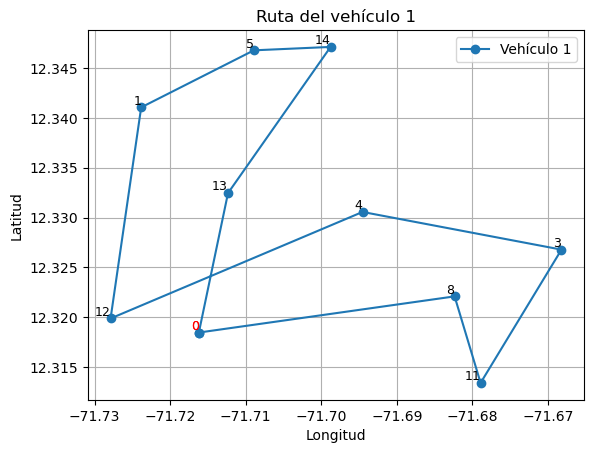

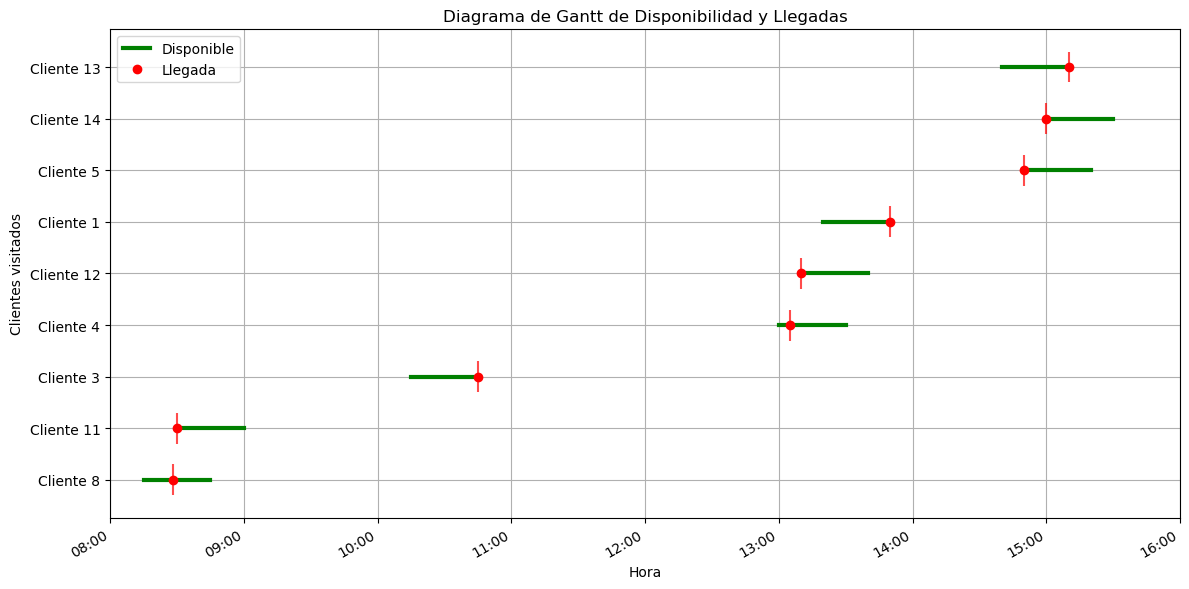

______________________________________________________________
Vehicle 2 route: [(0, 7), (6, 10), (7, 6), (10, 0)]
Vehicle 2 id: 2
Vehicle 2 type: Drone
Vehicle 2 initial load: 18.0 kg
Vehicle 2 satisfied demand: 18.0 kg
Vehicle 2 arrival time: 24:00-09:11-09:30-14:30-24:00
Vehicle 2 total time: 199.0 minutes
Vehicle 2 total cost: 2.54 $
[0, 7, 6, 10, 0]


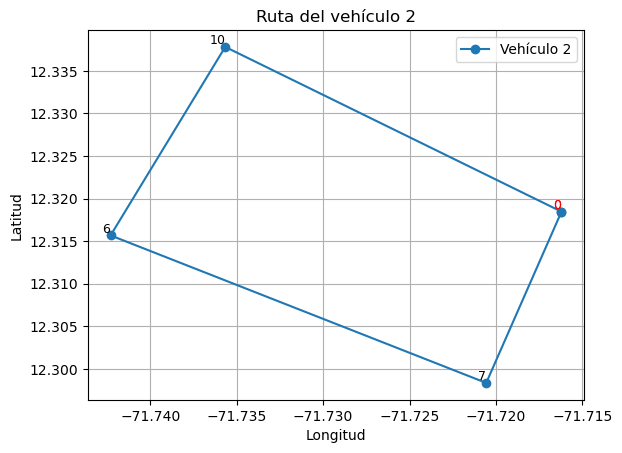

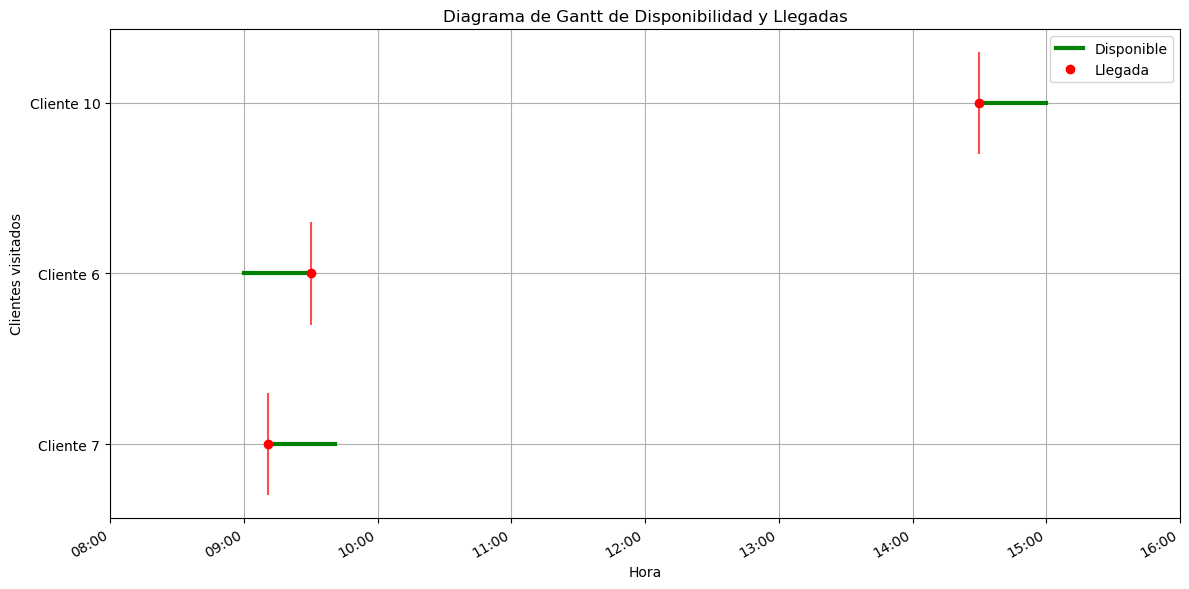

______________________________________________________________
Vehicle 3 route: [(0, 2), (2, 9), (9, 0)]
Vehicle 3 id: 3
Vehicle 3 type: Drone
Vehicle 3 initial load: 18.0 kg
Vehicle 3 satisfied demand: 18.0 kg
Vehicle 3 arrival time: 24:00-13:30-14:48-24:00
Vehicle 3 total time: 78.0 minutes
Vehicle 3 total cost: 1.19 $
[0, 2, 9, 0]


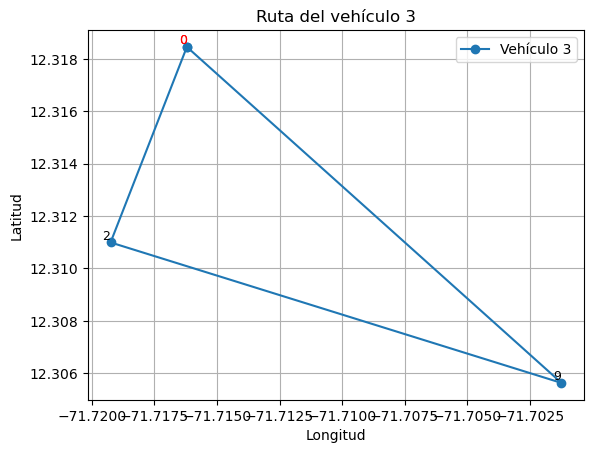

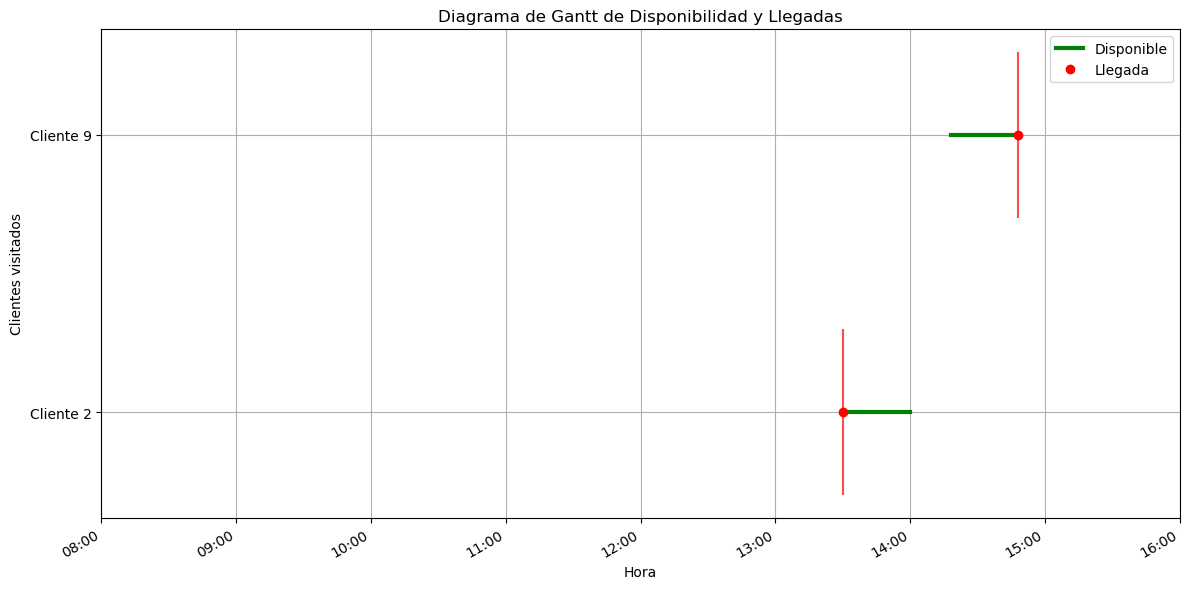

In [156]:
print("Routes:")

data_verificacion = []

for k in model.V:
    route = []
    for i in model.N:
        for j in model.N:
            if model.x[i, j, k].value is not None and model.x[i, j, k].value > 0:
                route.append((i, j))
    if route:
        lista_datos = []
        print("______________________________________________________________")
        print(f"Vehicle {k} route: {route}")

        
        # agregar datos a lista datos

        # vehicle id

        vehicle_id_str = ""
        k_str = str(k)
        tipo = ""
        

        if tipo_vehiculo[k-1] == 1:
            vehicle_id_str = "TRK"+ k_str.zfill(3)
            tipo = "Truck"
        else:
            vehicle_id_str = "DRN"+ k_str.zfill(3)
            tipo = "Drone"
            
        
        print(f"Vehicle {k} id: {k}")
        

        # vehicle type
        lista_datos.append(vehicle_id_str)
        lista_datos.append(tipo)
        print(f"Vehicle {k} type: {tipo}")
        
        # Initial load 

        carga = 0
        for i, j in route:
            if j in model.C:
                carga += De[j]
        print(f"Vehicle {k} initial load: {carga} kg")

        lista_datos.append(carga)


        # ruta y municipios atendidos

        ruta, municipalities,ruta_lista = get_route(route.copy())
        lista_datos.append(formatear_ruta(ruta))
        lista_datos.append(municipalities)

        # demanda satisfecha

        demanda = 0
        for i, j in route:
            if j in model.C:
                demanda += De[j]
        print(f"Vehicle {k} satisfied demand: {demanda} kg")
        lista_datos.append(demanda)

        # hora llegada cliente en hh:mms
        string_hora = ""
        list_horas = []
        lista_minutos = []
        for j in ruta_lista:
            list_horas.append(minutos_a_hhmm(model.TAki[k, j].value))
            lista_minutos.append(model.TAki[k, j].value)
            string_hora += minutos_a_hhmm(model.TAki[k, j].value) + "-"
        


        string_hora = string_hora[:-1]
        list_sin_inicial_final = list_horas[1:-1]  # Excluir el primer y último elemento (depot)

        string_hora = "-".join(list_horas)

        lista_datos.append("-".join(list_sin_inicial_final))
        print(f"Vehicle {k} arrival time: {string_hora}")


        
        # distancia recorrida

        distancia_recorrida = 0
        for i, j in route:
            distancia_recorrida += model.d[i, j, tipo_vehiculo[k-1]]
        
        distancia_recorrida = round(distancia_recorrida, 2)
        lista_datos.append(distancia_recorrida)
        
        # total tiempo recorrido
        
        # hora inicial - final

        inicial = lista_minutos[1]
        final = lista_minutos[-2]

        tiempo_recorrido = dehhmm_a_minutos(final) - dehhmm_a_minutos(inicial)
        tiempo_recorrido = round(tiempo_recorrido, 2)

        lista_datos.append(tiempo_recorrido)
        print(f"Vehicle {k} total time: {tiempo_recorrido} minutes")

        # total costo

        total_costo = 0
        for i, j in route:
            total_costo += model.cost[i, j, tipo_vehiculo[k-1]] * model.x[i, j, k].value
        
        total_costo = round(total_costo, 2)
            
        print(f"Vehicle {k} total cost: {total_costo} $")
        lista_datos.append(total_costo)
        # agregar lista de datos a data_verificacion
        data_verificacion.append(lista_datos)
        print(ruta_lista)
        graficar_ruta(ruta_lista, k)
        graficar_diagrama_gantt(ruta_lista, VT, string_hora)
        

        





In [157]:
columnas = ["VehicleId", "VehicleType", "InitialLoad", "RouteSequence", "ClientsServed", "DemandSatisfied",
            "ArrivalTimes", "TotalDistance", "TotalTime", "Cost"]

# guardar en un csv

print(data_verificacion)
df = pd.DataFrame(data_verificacion, columns=columnas)
df.to_csv("datos/caso_2/verificacion_caso2.csv", index=False)
print("Data verification saved in datos/caso_2/verificacion_caso2.csv")
print("Data verification:")
print(df)
print("______________________________________________________________")



[['TRK001', 'Truck', 149.0, 'CD-COM08-COM11-COM03-COM04-COM12-COM01-COM05-COM14-COM13-CD', 9, 149.0, '08:28-08:30-10:45-13:05-13:10-13:50-14:50-15:00-15:10', 29.1, 241.35, 16.59], ['DRN002', 'Drone', 18.0, 'CD-COM07-COM06-COM10-CD', 3, 18.0, '09:11-09:30-14:30', 10.92, 199.0, 2.54], ['DRN003', 'Drone', 18.0, 'CD-COM02-COM09-CD', 2, 18.0, '13:30-14:48', 5.1, 78.0, 1.19]]
Data verification saved in datos/caso_2/verificacion_caso2.csv
Data verification:
  VehicleId VehicleType  InitialLoad  \
0    TRK001       Truck        149.0   
1    DRN002       Drone         18.0   
2    DRN003       Drone         18.0   

                                       RouteSequence  ClientsServed  \
0  CD-COM08-COM11-COM03-COM04-COM12-COM01-COM05-C...              9   
1                            CD-COM07-COM06-COM10-CD              3   
2                                  CD-COM02-COM09-CD              2   

   DemandSatisfied                                       ArrivalTimes  \
0            149.0  08:28-